In [1]:
import tensorflow as tf
import os
from src.utils import reload_model_from_epoch
from src.modeling.preprocess import load, resize, load_image_and_sketch
from src.preprocessing import find_sketch_threshold, dog
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
from tensorflow.io import read_file, decode_jpeg
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

2023-02-10 12:18:09.339088: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 12:18:09.437216: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-10 12:18:09.437236: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-10 12:18:10.053503: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-1

In [2]:
def get_example_sketches_at_thresholds(image_file, fill_space_thresholds):
    image = Image.open(image_file)
    
    sketches = []
    
    for threshold in fill_space_thresholds:
        sketches.append(find_sketch_threshold(image, fill_space_threshold = threshold))
        
    return sketches

In [67]:
def display_sketch_thresholds(image_file, fill_space_thresholds, sketches):
    fig, ax = plt.subplots(1, 5, figsize = (18, 10));

    for i in range(4):
        ax[i].imshow(sketches[i][0], cmap = 'gray');
        ax[i].set_xlabel(f'Threshold {fill_space_thresholds[i]}\nGamma: {sketches[i][1]}',
                         labelpad = 10, fontsize = 16);
        ax[i].get_xaxis().set_ticks([]);
        ax[i].get_yaxis().set_ticks([]);

    ax[4].imshow(Image.open(image_file), cmap = 'gray');
    ax[4].set_xlabel('Ground-Truth', labelpad = 10, fontsize = 16);
    ax[4].get_xaxis().set_ticks([]);
    ax[4].get_yaxis().set_ticks([]);
    plt.subplots_adjust(wspace = 0, hspace = 0);
    
    return fig, ax

In [2]:
image_files = [
    '../data/raw/actual_owls/grayscale/Owl_Grayscale_0045.jpg',
    '../data/raw/actual_owls/grayscale/Owl_Grayscale_0534.jpg'
]

# fill_space_thresholds = [0.01, 0.03, 0.05, 0.07]
# sketch_groupings = [get_example_sketches_at_thresholds(image, fill_space_thresholds) for image in image_files]

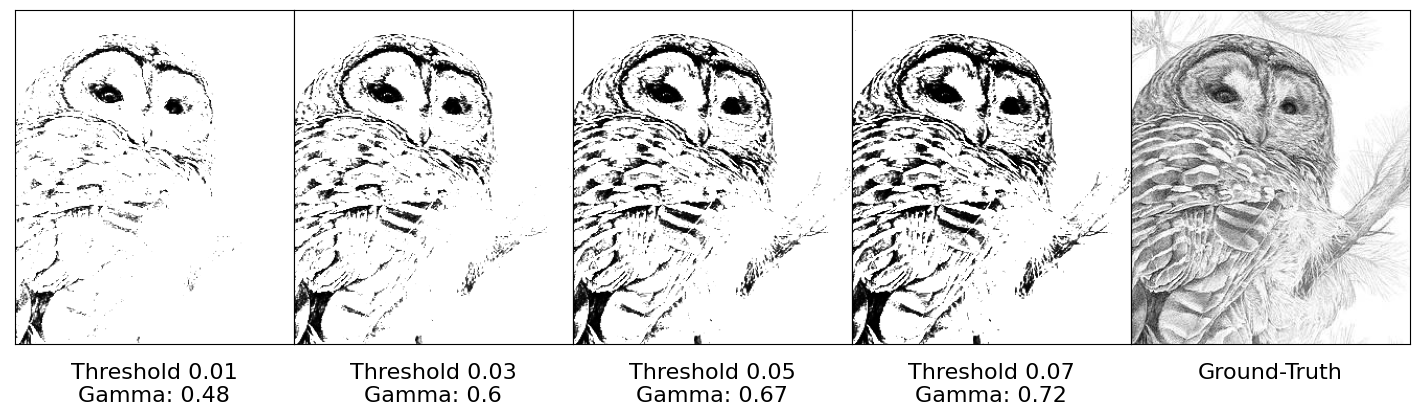

In [73]:
fig = display_sketch_thresholds(image_files[0], fill_space_thresholds, sketch_groupings[0]);
plt.savefig('../visualizations/DoG/sketch_thresholds_01.png', format = 'png', bbox_inches = 'tight');
plt.show();

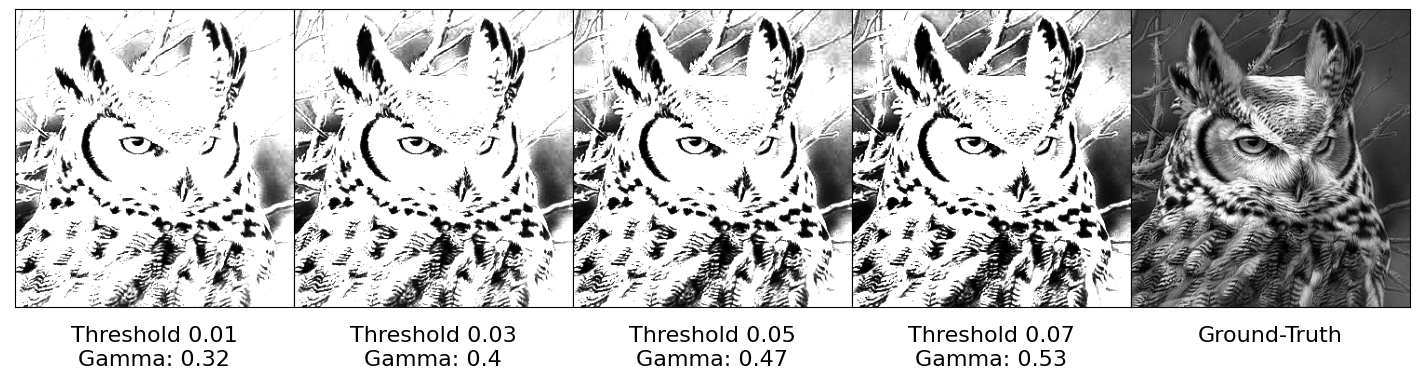

In [74]:
fig = display_sketch_thresholds(image_files[1], fill_space_thresholds, sketch_groupings[1])
plt.savefig('../visualizations/DoG/sketch_thresholds_02.png', format = 'png', bbox_inches = 'tight');
plt.show();

In [37]:
def display_dog_mixtures(gauss_mixtures, gammas):
    fig, ax = plt.subplots(1, 4, figsize = (14, 10));

    for i in range(4):
        ax[i].imshow(np.uint8(gauss_mixtures[i]), cmap = 'gray', vmin = 0, vmax = 255);
        ax[i].set_xlabel(f'Gamma: {gammas[i]}', labelpad = 10, fontsize = 16);
        ax[i].get_xaxis().set_ticks([]);
        ax[i].get_yaxis().set_ticks([]);
    plt.subplots_adjust(wspace = 0, hspace = 0);
    
    return fig, ax

In [25]:
gammas = [0.48, 0.6, 0.67, 0.72]

gauss_blurs = dog(np.array(Image.open(image_files[0])), size = (0, 0), sigma = 0.6, k = 200, gamma = 0.98)[0:2]
gauss_mixtures = [dog(np.array(Image.open(image_files[0])), size = (0, 0), sigma = 0.6, k = 200, gamma = gamma)[-1]\
                         for gamma in gammas]

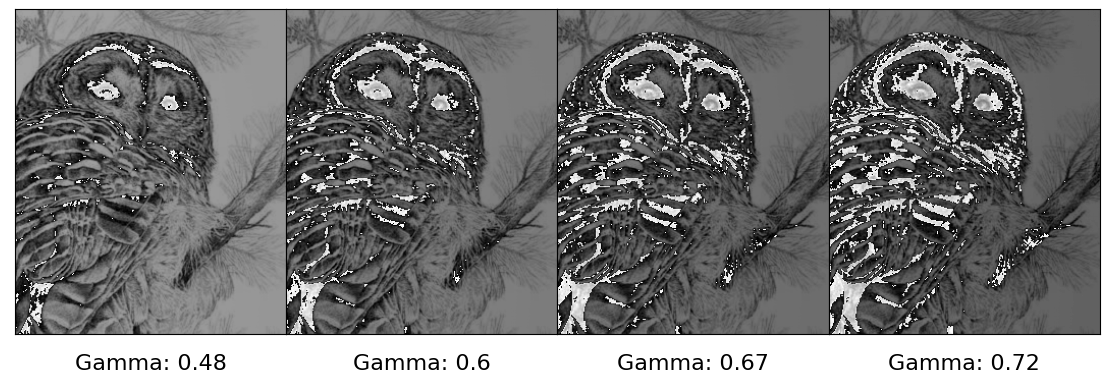

In [38]:
dog_mixtures = display_dog_mixtures(gauss_mixtures, gammas)
plt.savefig('../visualizations/DoG/gauss_mixtures.png', format = 'png', bbox_inches = 'tight');
plt.show()

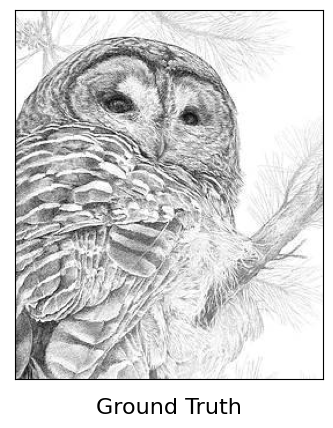

In [44]:
plt.imshow(Image.open(image_files[0]), cmap = 'gray', vmin = 0, vmax = 255);
plt.xlabel('Ground Truth', labelpad = 10, fontsize = 16);
plt.xticks([], []);
plt.yticks([], []);
plt.savefig('../visualizations/DoG/ground_truth_owl.png', format = 'png', bbox_inches = 'tight')

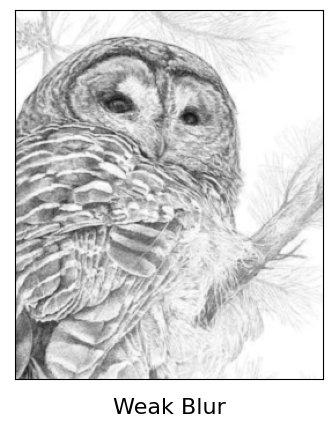

In [45]:
plt.imshow(Image.fromarray(gauss_blurs[0]), cmap = 'gray', vmin = 0, vmax = 255);
plt.xlabel('Weak Blur', labelpad = 10, fontsize = 16);
plt.xticks([], []);
plt.yticks([], []);
plt.savefig('../visualizations/DoG/weak_gauss_blur.png', format = 'png', bbox_inches = 'tight')

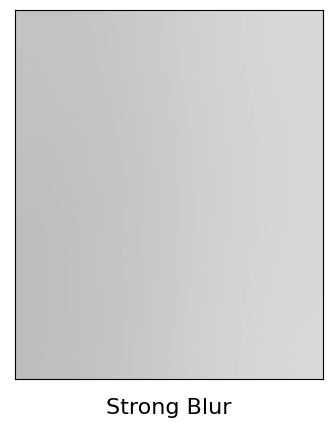

In [46]:
plt.imshow(Image.fromarray(gauss_blurs[1]), cmap = 'gray', vmin = 0, vmax = 255);
plt.xlabel('Strong Blur', labelpad = 10, fontsize = 16);
plt.xticks([], []);
plt.yticks([], []);
plt.savefig('../visualizations/DoG/strong_gauss_blur.png', format = 'png', bbox_inches = 'tight')